# Building VGG and Wide Residual Networks in Keras for Image Classification

#### An introduction to rapid network prototyping with Keras.
***

In this tutorial I demonstrate how Keras can be used to quickly implement deep learning architectures for rapid prototyping. Specifically, I build and train two networks on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10 dataset</a> with **image augmentation**:
1. A simplified **<a href="https://arxiv.org/abs/1409.1556" target="_blank">VGG architecture</a>** using the **Keras Sequential API**. 
2. A **<a href="https://arxiv.org/abs/1605.07146" target="_blank">Wide Residual Network</a> (WRN)** using the **Keras Functional API**. 

**Why Keras?**
In my <a href="https://rpmarchildon.com/ai-cnn-digits/" target="_blank">earlier tutorial</a> I demonstrated how to use the low-level TensorFlow API to build and train a simple convolutional neural network (CNN). But such an approach is code-heavy and quickly becomes cumbersome when trying to rapidly prototype multiple ideas. Keras was designed to eliminate much of this overhead, making it faster to move from idea to experiment. 

As well-articulated by Keras creator Francois Chollet <a href="https://www.quora.com/Why-has-Keras-been-so-successful-lately-at-Kaggle-competitions/answer/Fran%C3%A7ois-Chollet" target="_blank">in his post</a> on the recent success of Keras in winning Kaggle competitions: 
>*"Your final models will typically share little in common with the solutions you envisioned when first approaching the problem, because ...a-priori plans basically never survive confrontation with experimental reality. So winning is not so much about how good your theoretical vision is, it's about how much contact with reality your vision has been through. ...\[Using\] Keras allows you to iterate faster, to try more things. Ultimately, this enables you to win competitions (or publish papers). Being able to go from idea to result with the least possible delay is key to doing good research —that’s one of the core beliefs behind Keras."*


***
### Contents:

1. [**Data Preparation**](#section_1)
2. [**Building a Simplified VGG Network with the Keras Sequential API
**](#section_2)
3. [**Building a Wide ResNet (WRN) with the Keras Functional API**](#section_3)
4. [**Final Remarks**](#section_4)

### Import Libraries

In [1]:
import pickle
import os
import math
import numpy as np

from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import Image

import tensorflow as tf
import keras as K

from keras.layers import Input, Conv2D, Dense
from keras.layers import BatchNormalization, SpatialDropout2D
from keras.layers import Activation, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

print('Keras Version:', K.__version__)
print('Keras Backend:', K.backend.backend())
print('Keras Image Data Format:', K.backend.image_data_format())
print('TensorFlow Version:', tf.__version__)


Keras Version: 2.2.2
Keras Backend: tensorflow
Keras Image Data Format: channels_last
TensorFlow Version: 1.6.0


Using TensorFlow backend.


<a id='section_1'></a>
***
## 1) Data Preparation

### About the Dataset

The CIFAR-10 dataset (<a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">found here</a>) consists of 32x32-pixel RGB colour images of 10 classes (see below), with 6000 image samples per class. There are 50,000 training images and 10,000 test images in total. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the University of Toronto, and are a labeled subset of the <a href="http://groups.csail.mit.edu/vision/TinyImages/" target="_blank">"80 million tiny images"</a> dataset.

The 10 classes are:
> 0. `airplane` 
1. `automobile`
2. `bird`
3. `cat`
4. `deer`
5. `dog`
6. `frog`
7. `horse`
8. `ship`
9. `truck`


### Load and Reshape Data

General instructions for unpacking the data are found <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">here</a>. Each image data vector has 3072 elements. The first 1024 entries contain the red channel values, the next 1024 are the green values, and the final 1024 are the blue values. We reshape these vectors into arrays of dimension (32, 32, 3), where the third axis is the RGB channel. We reserve the final 5000 training images for our validation set. 

In [2]:
# define data directory and helper functions
DATA_PATH = "/home/rpm/ML-models/cifar-10-batches-py/"

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batch(batch_name):
    batch = os.path.join(DATA_PATH, batch_name)
    batch_dict = unpickle(batch)
    print('Loading %s' % batch_dict[b'batch_label'].decode('ascii'))
    X_data_ = batch_dict[b'data']
    X_data_ = X_data_.reshape(10000, 3, 32, 32)  # separate RGB channels
    X_data_ = X_data_.transpose(0,2,3,1).astype("float")  # re-order
    y_labels_ = batch_dict[b'labels']
    img_filenames_ = batch_dict[b'filenames']
    return (X_data_, y_labels_, img_filenames_)
    
# load training data
TRAIN_BATCH_LIST = [("data_batch_%s" % i) for i in range(1,6)]
X_arrs, y_arrs, name_arrs = [], [], []
for batch_name in TRAIN_BATCH_LIST:
    (X_arr, y_arr, name_arr) = load_batch(batch_name)
    X_arrs.append(X_arr)
    y_arrs.append(np.array(y_arr))
    name_arrs.append(name_arr)
X_train = np.vstack(X_arrs).astype('float32')
y_train = np.hstack(y_arrs)
img_filenames_train = np.vstack(name_arrs)
    
# load test data     
(X_test, y_test, img_filenames_test) = load_batch('test_batch')
y_test = np.array(y_test)

# ensure desired data format
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# define label dictionary
label_dict = {0: 'airplane', 
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

# use final 5000 training samples (10%) as validation set
X_val = X_train[45000:].astype('float32')
y_val = y_train[45000:]
X_train = X_train[:45000].astype('float32')
y_train = y_train[:45000]

# print data shapes
print('\nX_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

Loading training batch 1 of 5
Loading training batch 2 of 5
Loading training batch 3 of 5
Loading training batch 4 of 5
Loading training batch 5 of 5
Loading testing batch 1 of 1

X_train shape: (45000, 32, 32, 3)
X_val shape: (5000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (45000,)
y_val shape: (5000,)
y_test shape: (10000,)


### Display Sample Images
Let's have a look at 8 sample images from each class:

airplane


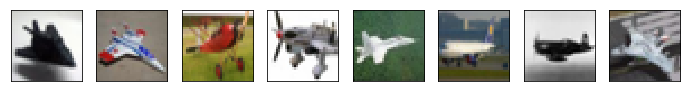

automobile


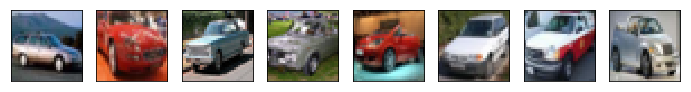

bird


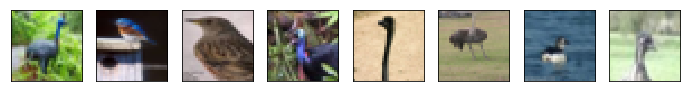

cat


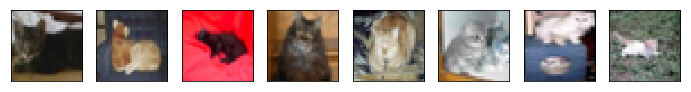

deer


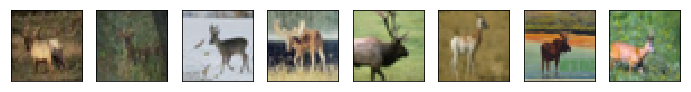

dog


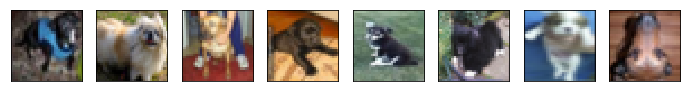

frog


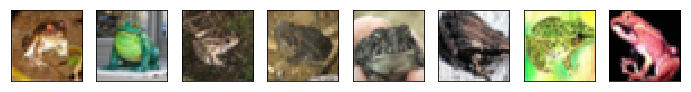

horse


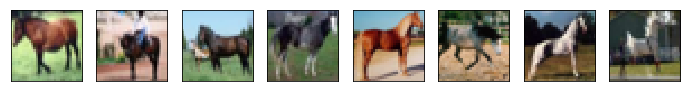

ship


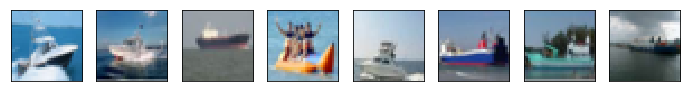

truck


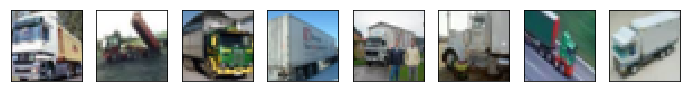

In [3]:
for j in range(10):
    print(label_dict[j])
    fig, ax = plt.subplots(nrows=1, ncols=8, 
                           sharex=True, sharey=True, 
                           figsize=(12, 8))
    ax = ax.flatten()    
    for i in range(8):

            img = X_train[y_train == j][i].astype('uint8')
            ax[i].imshow(img, interpolation='None')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()

### Data Preprocessing and Image Augmentation

First let's use Keras's pre-built onehot encoder to define a convenient function for one-hot encoding our class labels later on during model training and evaluation. 

In [4]:
def get_onehot(y_data, num_classes=10):
    return K.utils.to_categorical(y_data, num_classes)

Next we'll implement **image augmentation**, which is a technique for improving the generalization of our models by applying randomized image transformations (such as shifts, rotations, shears, zooms, and flips) to the original dataset. This helps force the model to learn feature maps that are more robust and relevant. We are essentially creating a larger training dataset from a smaller one. For excellent introductory articles on this topic, see these posts by <a href="https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced" target="_blank">Bharath Raj</a> and <a href="https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085" target="_blank">Ryan Allred</a>.

For our WRN model, it turns out that image augmentation is essential, otherwise our network basically just memorizes our training set (training accuracy reaches 100%) and yields poor generalization to the test set. 

Fortunately Keras has <a href="https://keras.io/preprocessing/image/" target="_blank">built-in tools</a> for applying image augmentation, with examples available <a href="https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html" target="_blank">here</a>.

We'll base our image augmentation on the scheme recommended by Sergey Zagoruyko and Nikos Komodakis in their <a href="https://arxiv.org/abs/1605.07146" target="_blank">seminal paper on Wide ResNets</a> (WRNs). Quoting their paper:

> *"For data augmentation we do horizontal flips and take random crops from image padded by 4 pixels on each side, filling missing pixels with reflections of original image. We don’t use heavy data augmentation... Unless mentioned otherwise, for CIFAR we follow the image preprocessing of [8] with ZCA whitening."*

Note that **ZCA whitening** is a linear algebra transformation, similar to principal component analysis (PCA), that reduces pixel redundancy to better highlight the key structures and features in the image. We'll use ZCA whitening to preprocess and standardize our data. We'll also look at how it compares to typical data standardization (mean/std) for our particular WRN model. 

Below we create generators for augmented images that also apply ZCA whitening and feature normalization. 

In [5]:
# augmented image generator based on scheme
# recommended by Zagoruyko and Komodakis
train_datagen_1 = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=True, 
    zca_epsilon=1e-06, 
    rotation_range=0.0, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='reflect', 
    cval=0.0, 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0)

# an alternative image augmentation scheme
# using zooms, rotations, and shears
train_datagen_2 = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=True, 
    zca_epsilon=1e-06, 
    rotation_range=15.0, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=None, 
    shear_range=0.2, 
    zoom_range=0.2, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0)

# for the test set, apply ZCA and centering only
test_datagen = ImageDataGenerator(
    featurewise_center=True,                        
    zca_whitening=True,                     
    data_format='channels_last')

# data normalization and ZCA whitening require our 
# generators to first be fit on our training data
train_datagen_1.fit(np.vstack((X_train, X_val)))
train_datagen_2.fit(np.vstack((X_train, X_val)))
test_datagen.fit(np.vstack((X_train, X_val)))


#### Visualizing the ImageDataGenerator Output

Let's have a look at what our image augmentation schemes produce for a sample input image. To make this easier to see, I've defined two new generators with the ZCA whitening transformation removed.

In [6]:
# sample image to augment
x_temp = X_train[4].reshape(1, 32, 32, 3)

# recreate the generators but without ZCA whitening
demo_datagen_1 = ImageDataGenerator(
    rotation_range=0.0, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    fill_mode='reflect', 
    horizontal_flip=True, 
    data_format='channels_last')

demo_datagen_2 = ImageDataGenerator(
    rotation_range=15.0, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    fill_mode='nearest', 
    horizontal_flip=True, 
    data_format='channels_last')


Data Augmentation Scheme 1:


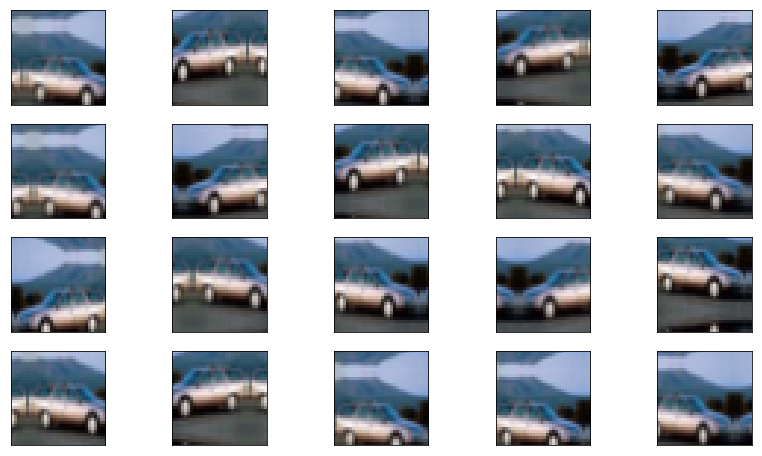

In [7]:
# plot examples from scheme 1
print('\nData Augmentation Scheme 1:')
i=0
figure = plt.figure(figsize=(14, 8))
for batch in demo_datagen_1.flow(x_temp, batch_size=1):
    # display the images
    ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    img = np.squeeze(batch).astype('uint8')
    ax.imshow(img, interpolation='nearest')
    i+=1
    if i==20:  # otherwise the generator would continue indefinitely
        break


Data Augmentation Scheme 2:


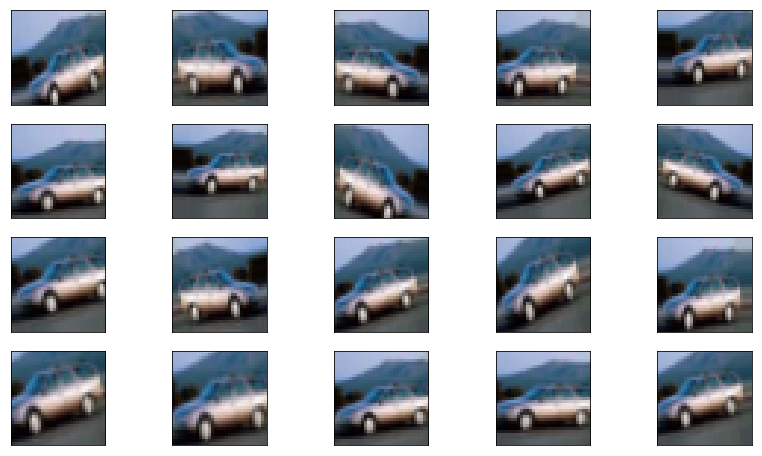

In [8]:
# plot examples from scheme 2
print('\nData Augmentation Scheme 2:')
i=0
figure = plt.figure(figsize=(14, 8))
for batch in demo_datagen_2.flow(x_temp, batch_size=1):
    # display the images
    ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    img = np.squeeze(batch).astype('uint8')
    ax.imshow(img, interpolation='nearest')
    i+=1
    if i==20:  # otherwise the generator would continue indefinitely
        break

<a id='section_2'></a>
***
## 2) Building a Simplified VGG Network with the Keras Sequential API

We'll first turn our attention to the famous <a href="https://arxiv.org/abs/1409.1556" target="_blank">VGG (Visual Geometry Group) architecture</a>, which was highly influential in its approach to convolutional networks for image recognition. Compared to earlier architectures, VGG was remarkable in both its simplicity and its layer depth. It is based on a heirarchical representation of visual data that makes it possible for smaller convolutional filter sizes (e.g. 3x3 pixels) to capture rich feature information so long as the network is sufficiently deep. To better appreciate VGG's place in the evolution of state-of-the-art networks for image recognition, I recommend reading <a href="https://dataconomy.com/2017/04/history-neural-networks/" target="_blank">this article</a> on the history of neural networks by Prof. Eugenio Culurciello at Purdue University. 

The core design rules of VGG network construction are as follows:

> 1. For a given output feature map size (e.g. 32x32 or 16x16), you use the same number filters (channels) for each convolution layer. 
2. Each time the feature map size is halved (e.g. by maxpooling with a stride of 2), you double the number of filters (channels) to maintain the same "time complexity per layer". 
3. You end with a global average pooling layer followed by fully-connected (dense) layers and softmax. 

A table summarizing various VGG models, taken from the original research paper, is shown below, where `convN-K` refers to a convolutional layer having filter size `NxN` pixels and `K` filter channels. 

<img src="http://rpmarchildon.com/wp-content/uploads/2018/09/VGG-Description.png" alt="Drawing" style="width: 600px;"/>

The relative simplicity of VGG makes it an excellent first example for showing how we can build such networks in Keras. On the other hand, its large number of trainable parameters makes it computationally expensive. Hence we'll implement a simplified version of VGG that is similar to configuration B (see table above) but has one less convolution block and only one fully-connected dense layer at the output.

### Building the VGG Model

For architectures such as VGG where all network layers are arranged in serial, we can use Keras' `Sequential API` for model construction. We first create an instance of the `Sequential()` model object, and then chronologically add layers. The pre-built network layers we'll be using include `Conv2D`, `BatchNormalization`, `MaxPooling2D`, and `Dense`. A `Flatten` layer is used to concatenate and reshape all feature maps into a single vector prior to applying the fully-connected layer. The handy `summary()` method allows us to view details about the model, including the number of trainable and non-trainable parameters. 

In [9]:
def build_SVGG():

    model = K.Sequential()

    # 1. First Conv block
    model.add(Conv2D(filters=64, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu',
                     input_shape=(32, 32, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=64, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))

    
    # 2. Second Conv block
    model.add(Conv2D(filters=128, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=128, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))


    # 3. Third Conv block
    model.add(Conv2D(filters=256, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(filters=256, 
                     kernel_size=3, 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=2))


    # 4. Dense layer with dropout applied to flattened data
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(1024, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.Dense(10, activation='softmax'))
    
    return model

# for inspection purposes
model_SVGG = build_SVGG()
model_SVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
__________

We see that this simplified VGG model has roughly **5.3 million** parameters. 

### Model Compilation and Helper Functions

Before we train our model, we need to compile it using the `compile()` method. It is at this time that we specify:
1. the loss function to be used during optimization,
2. the optimization technique, and 
3. the metrics to be used for evaluating model performance. 

For example, to train a model using categorical cross-entropy loss with optimization via stochastic gradient descent while tracking accuracy as the performance metric, we use:

> model_SVGG.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', 
                  metrics=['accuracy'])

There are a few other things we need to know about before proceeding. One is about the use of **callbacks**. Callbacks allow us to apply functions or access model parameters during the training process. For example, we can use callbacks to access the model weights after each training iteration and save these to file if they result in a better minimization of the loss function than previous iterations. We can also use callbacks to generate TensorBoard files for viewing a model's performance and for detailed visualization of its computational graph. For more about callbacks, see the <a href="https://keras.io/callbacks/" target="_blank">Keras documentation</a>. 

Finally, one typically trains, evaluates, and utilizes Keras models by calling the `fit()`, `evaluate()`, and `predict()` methods respectively. In this case, however, when working with data generators for image augmentation, we need to call slightly different methods, namely `fit_generator()`, `evaluate_generator()`, and `predict_generator()`, where our train and test set data generators are given as arguments. Note that we cannot mix these sets of methods: even though we don't use image augmentation on the test set, we cannot simply standardize the test data and call `predict()` after training a model with `fit_generator()`; doing so will yield erroneous results, hence why we use a generator for the test set.  

Calling `fit()` or `fit_generator()` on a model object returns a history object that we can use to plot training and validation accuracy as a function of training epochs, which is great for assessing how well the model converges and its generalization (e.g. bias-variance tradeoff). 

Below we define some helper functions that make it easier for us to train and evaluate our Keras models with fewer lines of repeated code: 

In [10]:
# perform all tasks related to model training
def compile_and_train(model, 
                      MODEL_NAME,
                      X_train_data, 
                      y_train_data, 
                      X_val_data, 
                      y_val_data,
                      train_generator,
                      test_generator,
                      BATCH_SIZE, 
                      EPOCHS,
                      optimizer='rmsprop', 
                      lr_schedule_fn=None,
                      starting_epoch=0):
    
    # directory setup for saving model files
    MODEL_DIR = '/home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/'
    
    DIR = os.path.join(
        MODEL_DIR,           
        MODEL_NAME, 
        datetime.now().strftime('%Y%m%d-%H%M%S'))
    
    if not os.path.exists(DIR):
        os.makedirs(DIR)    
    
    LOG_DIR = os.path.join(DIR, 'logs')
    
    # checkpointer callback for saving best weights
    WEIGHT_DIR = os.path.join(DIR, 'best_weights.hdf5')
    checkpointer_cb = K.callbacks.ModelCheckpoint(
        filepath=WEIGHT_DIR, 
        verbose=1, 
        save_best_only=True)
        
    # callback to save tensorboard logs
    tensorboard_cb = TensorBoard(
        log_dir=LOG_DIR, 
        histogram_freq=0,            
        batch_size=BATCH_SIZE,           
        write_graph=True,           
        write_grads=False,           
        write_images=False)

    print('To view graph generated by TensorBoard,')
    print('copy+paste the following into terminal:')
    print('\ntensorboard --logdir=%s' % LOG_DIR)
    print('\n')
    
    # special callbacks for a scheduled learning rate
    if lr_schedule_fn is not None: 

        # learning rate scheduler
        lr_schedule_cb =K.callbacks.LearningRateScheduler(
            lr_schedule, verbose=0)

        # custom history callback
        class LossHistory(K.callbacks.Callback):
            def on_train_begin(self, logs={}):
                self.losses = []
                self.lr = []

            def on_epoch_end(self, batch, logs={}):
                self.losses.append(logs.get('loss'))
                self.lr.append(lr_schedule(len(self.losses)))

        loss_and_lr_history_cb = LossHistory()

        callback_list = [checkpointer_cb, 
                         tensorboard_cb, 
                         lr_schedule_cb,
                         loss_and_lr_history_cb]
    else:
    
        callback_list = [checkpointer_cb, 
                         tensorboard_cb]    

    # compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    # one-hot encode labels
    y_train_data_onehot = get_onehot(y_train_data)
    y_val_data_onehot = get_onehot(y_val_data)
    
    # prepare data generators
    train_gen = train_generator.flow(
        X_train_data, 
        y_train_data_onehot, 
        batch_size=BATCH_SIZE)
    
    val_gen = test_generator.flow(
        X_val_data, 
        y_val_data_onehot, 
        batch_size=BATCH_SIZE)
    
    # train the model
    history= model.fit_generator(
        generator=train_gen,    
        steps_per_epoch=len(X_train_data)/BATCH_SIZE,       
        epochs=EPOCHS,      
        verbose=1,      
        callbacks=callback_list,       
        validation_data=val_gen,    
        validation_steps=len(X_val_data)/BATCH_SIZE,        
        class_weight=None,       
        max_queue_size=10,         
        workers=1,       
        use_multiprocessing=False,       
        shuffle=True, 
        initial_epoch=starting_epoch)

    # save trained model (after final epoch) 
    model.save(os.path.join(DIR, 'model_WRN.h5'))
        
    if lr_schedule_fn is not None: 
        return (history, DIR, loss_and_lr_history_cb)
    else:
        return (history, DIR)

In [11]:
# function for plotting metrics versus
# training epoch from a history object
def plot_histories(history_):
    
    # summarize history for accuracy
    plt.plot(history_.history['acc'])
    plt.plot(history_.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
    return None


# helper function for evaluating performance
def evaluate_performance(model_obj, 
                         model_dir,
                         X_test_data,
                         y_test_data,
                         test_generator,
                         model_hist=None, 
                         model_lr_hist=None):
    
    # plot accuracies versus epoch
    if model_hist is not None:
        print('\nPlotting Training History:')
        plot_histories(model_hist)
        
    # plot learning rate if scheduled
    if model_lr_hist is not None:
        print('\nPlotting Learning Rate Schedule:')
        
        plt.plot(model_lr_hist.lr)
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')
        plt.show()

        plt.plot(model_lr_hist.losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()
    
    # one-hot encoding
    y_test_data_onehot = get_onehot(y_test_data)
    
    # prepare data generator
    test_gen = test_generator.flow(
        X_test_data, 
        y_test_data_onehot, 
        batch_size=1)
    
    # evaluate with End-Of-Training weights
    print('\nComputing EOT Score...')
    score_EOT = model_obj.evaluate_generator(
        generator=test_gen, 
        steps=len(y_test_data), 
        max_queue_size=10, 
        workers=1, 
        use_multiprocessing=False, 
        verbose=1)
    print('Test Accuracy with EOT Weights:', score_EOT[1])

    # evaluate with Best Weights
    model_obj.load_weights(
        os.path.join(model_dir, 'best_weights.hdf5'))
    
    print('\nComputing Best Weights Score...')
    score_BW = model_obj.evaluate_generator(
        generator=test_gen, 
        steps=len(y_test_data), 
        max_queue_size=10, 
        workers=1, 
        use_multiprocessing=False, 
        verbose=1)
    print('Test Accuracy with Best Weights:', score_BW[1])
    
    scores = (score_EOT[1], score_BW[1])
    
    return scores    

### Model Training

With our handy helper functions, we can now build and train the simplified VGG network in a few short chunks of code. Note that I'm substituting the test set as the validation set here, so we can see how the test accuracy evolves with model training --- I can do this here because in no way is the test set being used to update the model weights during training or to select hyperparameters. Although I made a validation set split earlier out of habit, here I'm training the model on the full 50000-sample training set. 

In [12]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_SVGG = build_SVGG()

# initiate training
this_name = 'SVGG_AugScheme1_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_SVGG,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_1,
    test_generator=test_datagen,
    BATCH_SIZE=128,                 
    EPOCHS=400,                
    optimizer='rmsprop',                
    lr_schedule_fn=None)

To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=/home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/SVGG_AugScheme1_FullTrainSet/20180917-212553/logs


Epoch 1/400
391/390 [==============================] - 94s 241ms/step - loss: 2.4747 - acc: 0.3377 - val_loss: 2.0399 - val_acc: 0.3977

Epoch 00001: val_loss improved from inf to 2.03992, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/SVGG_AugScheme1_FullTrainSet/20180917-212553/best_weights.hdf5
Epoch 2/400
391/390 [==============================] - 94s 241ms/step - loss: 1.6176 - acc: 0.5055 - val_loss: 1.3853 - val_acc: 0.5288

Epoch 00002: val_loss improved from 2.03992 to 1.38532, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/SVGG_AugScheme1_FullTrainSet/20180917-212553/best_weights.hdf5
Epoch 3/400
391/390 [==============================] - 103s 263ms/step - loss: 1.3972 - acc: 0.5690 - val_loss: 1.9149 - val_acc: 0.4996

Epoch 00003: val_loss did not imp

391/390 [==============================] - 117s 298ms/step - loss: 0.5660 - acc: 0.8552 - val_loss: 0.6066 - val_acc: 0.8420

Epoch 00038: val_loss improved from 0.63951 to 0.60662, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/SVGG_AugScheme1_FullTrainSet/20180917-212553/best_weights.hdf5
Epoch 39/400
391/390 [==============================] - 116s 297ms/step - loss: 0.5717 - acc: 0.8542 - val_loss: 0.6154 - val_acc: 0.8350

Epoch 00039: val_loss did not improve from 0.60662
Epoch 40/400
391/390 [==============================] - 137s 351ms/step - loss: 0.6044 - acc: 0.8522 - val_loss: 0.6539 - val_acc: 0.8475

Epoch 00040: val_loss did not improve from 0.60662
Epoch 41/400
391/390 [==============================] - 144s 369ms/step - loss: 0.5667 - acc: 0.8574 - val_loss: 0.8146 - val_acc: 0.8239

Epoch 00041: val_loss did not improve from 0.60662
Epoch 42/400
391/390 [==============================] - 144s 368ms/step - loss: 0.5777 - acc: 0.8576 - val_loss: 0.7076 - va

391/390 [==============================] - 97s 248ms/step - loss: 0.4904 - acc: 0.8849 - val_loss: 0.7002 - val_acc: 0.8677

Epoch 00122: val_loss did not improve from 0.46327
Epoch 123/400
391/390 [==============================] - 97s 248ms/step - loss: 0.4936 - acc: 0.8848 - val_loss: 0.7728 - val_acc: 0.8697

Epoch 00123: val_loss did not improve from 0.46327
Epoch 124/400
391/390 [==============================] - 94s 241ms/step - loss: 0.4738 - acc: 0.8861 - val_loss: 0.7912 - val_acc: 0.8594

Epoch 00124: val_loss did not improve from 0.46327
Epoch 125/400
391/390 [==============================] - 90s 230ms/step - loss: 0.4722 - acc: 0.8862 - val_loss: 0.8361 - val_acc: 0.8548

Epoch 00125: val_loss did not improve from 0.46327
Epoch 126/400
391/390 [==============================] - 92s 235ms/step - loss: 0.4902 - acc: 0.8865 - val_loss: 0.7441 - val_acc: 0.8571

Epoch 00126: val_loss did not improve from 0.46327
Epoch 127/400
391/390 [==============================] - 90s 230

391/390 [==============================] - 89s 227ms/step - loss: 0.5166 - acc: 0.8927 - val_loss: 0.9120 - val_acc: 0.8672

Epoch 00208: val_loss did not improve from 0.46327
Epoch 209/400
391/390 [==============================] - 88s 225ms/step - loss: 0.5328 - acc: 0.8922 - val_loss: 0.6911 - val_acc: 0.8694

Epoch 00209: val_loss did not improve from 0.46327
Epoch 210/400
391/390 [==============================] - 89s 228ms/step - loss: 0.5296 - acc: 0.8919 - val_loss: 0.7542 - val_acc: 0.8556

Epoch 00210: val_loss did not improve from 0.46327
Epoch 211/400
391/390 [==============================] - 88s 225ms/step - loss: 0.4964 - acc: 0.8924 - val_loss: 0.7433 - val_acc: 0.8683

Epoch 00211: val_loss did not improve from 0.46327
Epoch 212/400
391/390 [==============================] - 89s 227ms/step - loss: 0.4972 - acc: 0.8897 - val_loss: 0.7039 - val_acc: 0.8735

Epoch 00212: val_loss did not improve from 0.46327
Epoch 213/400
391/390 [==============================] - 89s 227

391/390 [==============================] - 112s 288ms/step - loss: 0.5081 - acc: 0.8963 - val_loss: 0.8003 - val_acc: 0.8807

Epoch 00294: val_loss did not improve from 0.46327
Epoch 295/400
391/390 [==============================] - 112s 286ms/step - loss: 0.5298 - acc: 0.8955 - val_loss: 0.7196 - val_acc: 0.8742

Epoch 00295: val_loss did not improve from 0.46327
Epoch 296/400
391/390 [==============================] - 112s 287ms/step - loss: 0.5217 - acc: 0.8951 - val_loss: 0.8532 - val_acc: 0.8762

Epoch 00296: val_loss did not improve from 0.46327
Epoch 297/400
391/390 [==============================] - 112s 287ms/step - loss: 0.5714 - acc: 0.8920 - val_loss: 0.9685 - val_acc: 0.8642

Epoch 00297: val_loss did not improve from 0.46327
Epoch 298/400
391/390 [==============================] - 112s 285ms/step - loss: 0.5222 - acc: 0.8931 - val_loss: 0.7247 - val_acc: 0.8717

Epoch 00298: val_loss did not improve from 0.46327
Epoch 299/400
391/390 [==============================] - 11

391/390 [==============================] - 123s 313ms/step - loss: 0.5484 - acc: 0.8925 - val_loss: 0.9558 - val_acc: 0.8731

Epoch 00380: val_loss did not improve from 0.46327
Epoch 381/400
391/390 [==============================] - 97s 249ms/step - loss: 0.5417 - acc: 0.8913 - val_loss: 1.0235 - val_acc: 0.8593

Epoch 00381: val_loss did not improve from 0.46327
Epoch 382/400
391/390 [==============================] - 97s 247ms/step - loss: 0.5661 - acc: 0.8921 - val_loss: 1.0102 - val_acc: 0.8554

Epoch 00382: val_loss did not improve from 0.46327
Epoch 383/400
391/390 [==============================] - 100s 255ms/step - loss: 0.5459 - acc: 0.8926 - val_loss: 0.9256 - val_acc: 0.8649

Epoch 00383: val_loss did not improve from 0.46327
Epoch 384/400
391/390 [==============================] - 101s 257ms/step - loss: 0.5287 - acc: 0.8926 - val_loss: 1.0156 - val_acc: 0.8650

Epoch 00384: val_loss did not improve from 0.46327
Epoch 385/400
391/390 [==============================] - 99s 

### Model Evaluation

Now let's run our evaluation helper function to see how this model did:


Plotting Training History:


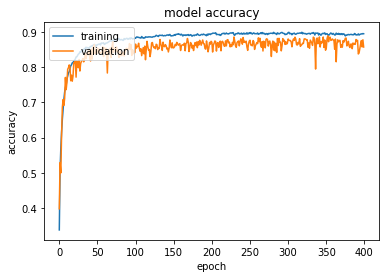

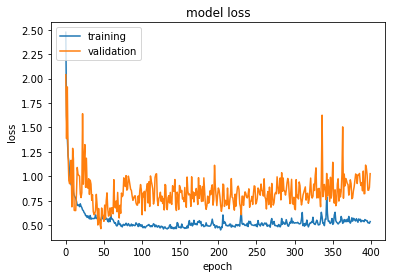


Computing EOT Score...
10000/10000 [==============================] - 29s 3ms/step
Test Accuracy with EOT Weights: 0.8568

Computing Best Weights Score...
10000/10000 [==============================] - 27s 3ms/step
Test Accuracy with Best Weights: 0.8637


In [13]:
# function for evaluating performance
this_score = evaluate_performance(
    model_obj=model_SVGG,   
    model_dir=this_dir,       
    X_test_data=X_test,     
    y_test_data=y_test,
    test_generator=test_datagen,
    model_hist=this_history,               
    model_lr_hist=None)


Performance on the training set saturates fairly quickly (around epoch 100) whereas the loss function for the valdiation set appears to reach an optimum near 50 epochs and then fluctuates significantly. To obtain better performance, we could try a different optimizer or specify a learning rate schedule. For now, we'll note **86.4%** as the test accuracy obtained by this model. 

### View Sample Predictions

Let's view a random sample of the images our trained model has classified correctly or incorrectly. The following code accomplishes this. 


**Displaying Correct Predictions**


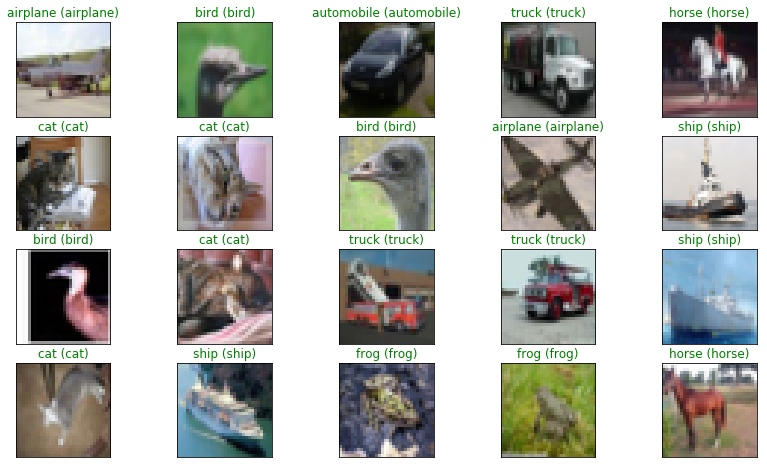

In [14]:
# generate the predictions
test_generator = test_datagen.flow(X_test, 
                                   get_onehot(y_test), 
                                   batch_size=1)

probas = model_SVGG.predict_generator(test_generator,
                                      steps=len(y_test))
preds_SVGG = np.argmax(probas, axis=1)

# function for viewing predictions
def view_predictions(model_, preds_, condition='None'):
    if condition is None:
        print('\n**Displaying 20 Randomly-Selected Predictions**')
        inds = np.arange(len(preds_))
    elif condition is 'Correct':
        print('\n**Displaying Correct Predictions**')
        inds = np.arange(len(preds_))[preds_ == y_test]
    elif condition is 'Incorrect':
        print('\n**Displaying Incorrect Predictions**')
        inds = np.arange(len(preds_))[preds_ != y_test]
    else:
        raise ValueError(
            'condition must be: "None", "Correct" or "Incorrect"')
        
    # plot 20 randomly-chosen samples
    figure = plt.figure(figsize=(14, 8))
    for i, index in enumerate(np.random.choice(inds, 
                                               size=20, 
                                               replace=False)):

        # display the images
        ax = figure.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(X_test[index].astype('uint8'), interpolation='None')

        # from one-hot encoded back to integer label
        pred_int = preds_[index]
        true_int = y_test[index]

        # set title: Prediction (True Class)
        ax.set_title("{} ({})".format(
            label_dict[pred_int], 
            label_dict[true_int]),
            color=("green" if pred_int == true_int else "red"))
        
    return None

# correct predictions
view_predictions(model_SVGG, preds_SVGG, condition='Correct')


**Displaying Incorrect Predictions**


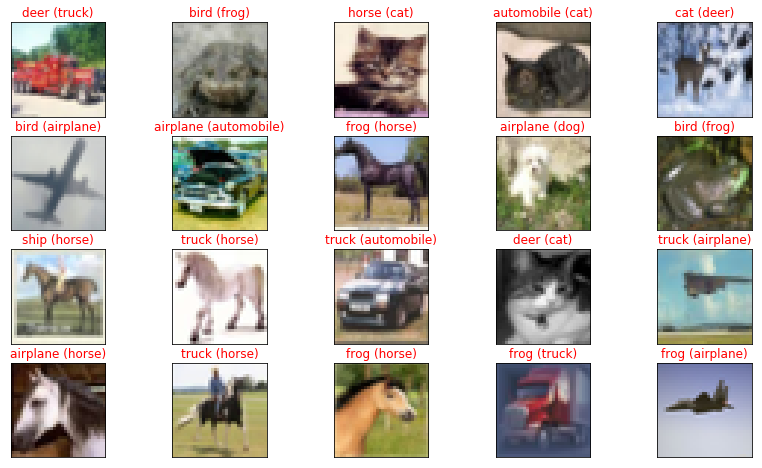

In [15]:
# incorrect predictions
view_predictions(model_SVGG, preds_SVGG, condition='Incorrect')

When dealing with convolutional neural networks, it's not always easy to understand why a particular image has been misclassified. However, if desired, we could examine the weights of the filter channels and network activations to get a better sense of which features are associated with each class. 

<a id='section_3'></a>
***
## 3) Building a Wide ResNet (WRN) with the Keras Functional API

Next we turn our attention to the slightly more challenging task of building a Wide Residual Network (WRN). Residual Networks (or ResNets) were considered a significant advance when they were first introduced. 

**Why ResNets?**

Prior to ResNets, the trend (with AlexNet, VGG, and Google's Inception networks) was to go deeper to achieve better performance. The issue with this was that deep networks are hard to train due to the vanishing gradient problem -- as the gradient is back-propagated to earlier layers, the repeated multiplication of small numbers can make it vanish, meaning that as the network gets deeper, its performance saturates or even starts to degrade. 

The core idea of ResNets is to introduce an "identity shortcut connection" (illustrated below, from <a href="https://arxiv.org/abs/1512.03385" target="_blank">the original paper</a>) that skips one or more layers, thereby creating additional shorter paths through which the gradient can flow. This allows for the training of extremely deep models with  hundreds layers -- in some cases, more than one thousand -- before vanishing gradients become problematic. This in turn led to new record performance on several benchmark image classification datasets. 

<img src="http://rpmarchildon.com/wp-content/uploads/2018/09/ResNetBlock.png" alt="Drawing" style="width: 400px;"/>

**Why "Wide" ResNets?**

It was later discovered, however, that randomly removing ResNet layers often had little to no impact on performance. Many ResNet layers appeared to be redundant or contributed negligible value. One explanation for this was that the large multiplicity of paths over which the gradient could flow meant that many ResNet layer weights could be effectively 'skipped over' during backpropagation and hence were not participating efficiently in learning.

This led to further experimentation, and it was found that making ResNets "wider", as opposed to deeper, could result in improved performance, far fewer layers, and faster training. An oft-quoted remark is that a 6-layer Wide ResNet (WRN) can have an accuracy similar to that of a 1000-layer deep conventional ResNet. 

**WRN Design Rules**
The basic design rules for WRNs, as laid out in <a href="https://arxiv.org/abs/1605.07146" target="_blank">this seminal paper</a> by Sergey Zagoruyko and Nikos Komodakis, are as follows:

> 1. Convolution filters should be no larger than 3x3 pixels for best performance (unless a bottleneck architecture is used). 
2. Follow the convention that when you downsample by 2, you double the number of feature maps (filter channels). 
3. Three important factors are introduced: `l`, the deepening factor, which represents the number of convolutional layers in a ResNet block (often l = 2 is optimal); `N`, the number of ResNet blocks (repeats; miniblocks) within a given convolutional group (wherein all layers in a group have the same fixed number of filter channels); and `K`, the widening factor, which multiplies the number of feature channels in each convolution layer. 
4. A batch normalization and ReLU activation precedes all convolution layers in ResNet blocks beyond the first block. 

Following these guidelines, the basic structure of a WRN given by the paper above is as follows:

<img src="http://rpmarchildon.com/wp-content/uploads/2018/09/WRN-Description.png" alt="Drawing" style="width: 400px;"/>

The conv1 group is the network input and has only one conv layer. Groups conv2, conv3, and conv4 are the residual block conv groups whose parameters are specified by `l` (implicitly `l = 2` here), `N`, and `K`. 

The common naming convention for identifying specific realizations of WRNs (with l = 2) is `WRN-n-K` where `n` is the total number of convolutional layers, and K is the widening factor. Note that `n` can take only specific values: we have 3 conv groups, each of which have 2 conv layers multiplied by `N` the number of miniblocks in each group, and there are always 4 additional conv layers (one in the input, and one at the beginning of each conv group in the residual path to match feature map sizes between groups). In our case, we'll work with **WRN-40-2**, which means that we have (40 -4)/(3x2) = 6 miniblocks in conv groups 2-4, and a widening factor of K=2. 

For more details, see the WRN creators' <a href="https://github.com/szagoruyko/wide-residual-networks" target="_blank">github page</a> for a network diagram. Their model was implemented in <a href="https://github.com/torch/nn" target="_blank">Torch</a>. 


**Additional Notes**

Zagoruyko and Komodakis reported a performance improvement when dropout was added between convolution layers. Note that this is typically not done when batch normalization (BN) is used, as dropout and BN often don't work well together (see <a href="https://arxiv.org/abs/1801.05134" target="_blank">this paper</a>). While BN is mostly a technique for improving optimization, it also happens to introduce noise, which can help with model generalization. And since for large datasets it is usually more important to optimize than to regularize well, BN is often preferred over dropout. 

Nonetheless, there can be exceptions where BN and dropout seem to complement each other (<a href="https://arxiv.org/abs/1606.03498" target="_blank">see here</a>, for example). I have chosen to follow the suggestion of Zagoruyko and Komodakis and include dropout, and have found that it does help here in improving the model performance.  

I have also chosen to follow their recommendations on the optimization technique:
> *"In all our experiments we use SGD with Nesterov momentum and cross-entropy loss. The
initial learning rate is set to 0.1, weight decay to 0.0005, dampening to 0, momentum to 0.9 and minibatch size to 128."*

### Building the WRN

The Keras functional API makes it easy to define layers that branch into parallel paths and the re-merge later. Note that we can also define auxillary inputs and loss functions, as well as define our own custom layer functions. For more, see the <a href="https://keras.io/getting-started/functional-api-guide/" target="_blank">official documentation</a>.

To use the functional API, we simply deploy our Keras built-in layers as functions like so: 

> `output_layer = LayerType(layer_parameters)(input_layer)` 

The logic of how this works will quickly become apparent in the following code blocks. 

In [10]:
def resnet_input_block(input_layer, 
                       num_filters):
    
    x = Conv2D(filters=num_filters, 
               kernel_size=3, 
               padding='same')(input_layer)
    
    x = BatchNormalization(axis=-1)(x)
    
    x_out = Activation('relu')(x)
    
    return x_out


def resnet_block(x_in, 
                 num_filters, 
                 num_miniblocks, 
                 downsampling,
                 dropout_rate=0.0):
    '''
    ** Input Parameters **
    
    x_in : input layer tensor (batchsize, width, height, channels)
    
    num_filters : total number of feature maps including
                  the widening factor multiplier
                 
    num_miniblocks : number of times we repeat the miniblock
                     (a.k.a. "groupsize" in the WRN paper)
                    
    downsampling : factor by which we reduce the output size, 
                   i.e. downsampling of 2 takes 16x16 --> 8x8;
                   downsampling here is applied by adjusting 
                   the stride of the first convolutional layers
                   rather than via pooling layers. 
                  
    ** Returns **
    
    x_out : output layer for the next network block
    
    '''
    
    # residual path
    x_res = Conv2D(filters=num_filters, 
                   kernel_size=1, 
                   padding='same',
                   strides=downsampling)(x_in)
    
    # main path mini-block
    x_main = Conv2D(filters=num_filters, 
                    kernel_size=3, 
                    padding='same',
                    strides=downsampling)(x_in)    
    
    x_main = BatchNormalization(axis=-1)(x_main)
    
    x_main = Activation('relu')(x_main)
    
    x_main = SpatialDropout2D(rate=dropout_rate)(x_main)
    
    x_main = Conv2D(filters=num_filters, 
                    kernel_size=3, 
                    padding='same')(x_main)
    
    # merge
    x_out = K.layers.Add()([x_main, x_res])
    
    
    # *** additional miniblocks ***
    for block in range(num_miniblocks-1):
        
        # main path mini-block
        x_main = BatchNormalization(axis=-1)(x_out)
        
        x_main = Activation('relu')(x_main)

        x_main = Conv2D(filters=num_filters, 
                        kernel_size=3, 
                        padding='same')(x_main)
        
        x_main = SpatialDropout2D(rate=dropout_rate)(x_main)
        
        x_main = BatchNormalization(axis=-1)(x_main)
        
        x_main = Activation('relu')(x_main)
        
        x_main = Conv2D(filters=num_filters, 
                        kernel_size=3, 
                        padding='same')(x_main)
        
        # merge
        x_out = K.layers.Add()([x_main, x_out])
    # ***
    
    
    # capping the resnet block 
    x = BatchNormalization(axis=-1)(x_out)

    x_out = Activation('relu')(x)
      
    return x_out


def resnet_output_block(x_in):
    
    # auto-adjust pooling based on input shape
    dim1_ = x_in.shape[1].value
    dim2_ = x_in.shape[2].value
    assert dim1_ == dim2_, 'Input layer dimensions must be square.'

    # this generates a single average value for each feature map
    x = K.layers.AveragePooling2D(pool_size=dim1_)(x_in)
    
    # flatten and apply a fully-connected layer 
    x = K.layers.Flatten()(x)
    
    x = Dense(128, activation='relu')(x)

    # obtain probabilities for each class
    class_probas = Dense(10, activation='softmax')(x)
    
    return class_probas


def build_WRN(num_convs=40, k_factor=2, drop_rate=0.0):
    """
    Builds a wide residual network (WRN) of type
    WRN-N-K where N is the total number of convolutions
    and K is the widening factor. 
    
    ** Input Parameters **
    
    num_convs: Total number of convolutions. Must be an 
               integer value derivable from (i * 2 * 3) + 4, 
               where i is an integer (e.g. 10, 16, 22, 28, 
               34, and 40 are acceptable values)
               
    k_factor: Widening factor, multiplies the number of channels
              in each resnet block convolution. Must be an 
              integer value. 
              
    drop_rate: Fraction of features dropped during SpatialDropout2D
               between conv layers in each residual block. 
              
    ** Returns **
    
    model: WRN model object built with Keras' functional API. 
    
    """
    assert type(num_convs) is int, \
    "num_convs is not an integer: %r" % num_convs
        
    assert type(k_factor) is int, \
    "k_factor is not an integer: %r" % k_factor
        
    assert num_convs in [10, 16, 22, 28, 34, 40], \
    "num_convs must be one of [10, 16, 22, 28, 34, 40]"
    
    num_miniblocks = int(math.ceil((num_convs - 4)/6))

    input_layer = Input(shape=(32, 32, 3))

    # input block ('conv1' group in WRN paper)
    x = resnet_input_block(input_layer, num_filters=16)

    # ('conv2' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=16*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # ('conv3' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=32*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # ('conv4' group in WRN paper)
    x = resnet_block(x_in=x, 
                     num_filters=64*k_factor, 
                     num_miniblocks=num_miniblocks, 
                     downsampling=2,
                     dropout_rate=drop_rate)

    # output block 
    probas = resnet_output_block(x_in=x)
    
    # assemble
    model = K.Model(inputs=input_layer, outputs=probas)
    
    return model

**Network Summary for WRN-40-2** 

Let's build WRN-40-2 with a dropout rate of 30% and view the model summary:

In [11]:
K.backend.clear_session()
model_WRN = build_WRN(40, 2, drop_rate=0.3)
model_WRN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

Our network has a total of **2.27 million** parameters, which is roughly half that of our earlier VGG model. 

**Visualizing the Network Graph**

With a more complex model such as a ResNet, it's useful to check our network construction by viewing its computational graph or displaying the relationship between its layers in a more visually intuitive format. Fortunately, Keras has a function called `plot_model` that allows us to easily accomplish this:

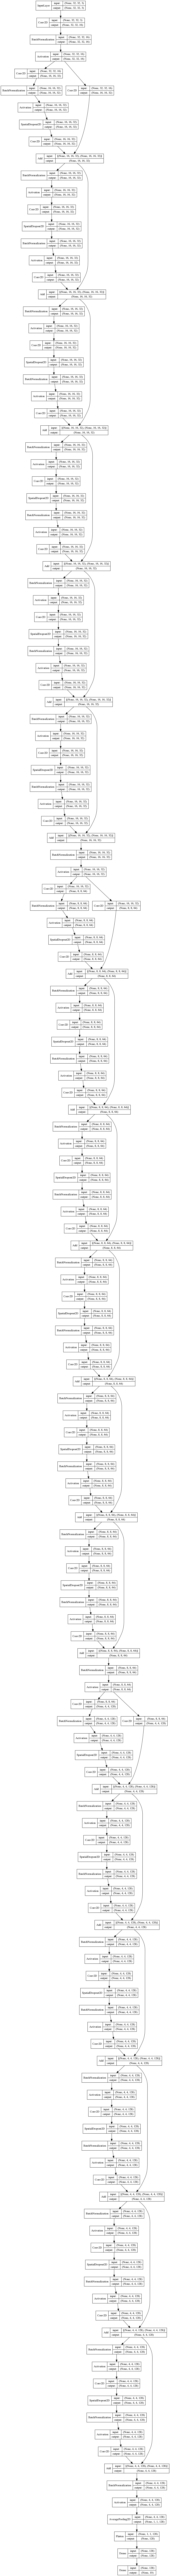

In [12]:
# visualizing the network
plot_model(model_WRN, to_file='model_plot.png', 
           show_shapes=True, show_layer_names=False)
Image('model_plot.png')

### Model Training

To train this WRN network, we call the same helper functions that we used for the VGG network. Quick and convenient! In fact, we could reuse these helper functions for any network model we define in Keras. 

In [13]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_WRN = build_WRN(40, 2, drop_rate=0.3)

# define the optimizer initial settings
sgd = K.optimizers.SGD(
    lr=0.1, 
    decay=0.0005,
    momentum=0.9, 
    nesterov=True)

# initiate training
this_name = 'WRN_AugScheme1_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_WRN,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_1,
    test_generator=test_datagen,
    BATCH_SIZE=128,                 
    EPOCHS=400,                
    optimizer=sgd,                
    lr_schedule_fn=None)

To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=/home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme1_FullTrainSet/20180916-094225/logs


Epoch 1/400
391/390 [==============================] - 102s 260ms/step - loss: 1.9376 - acc: 0.2674 - val_loss: 1.5945 - val_acc: 0.3899

Epoch 00001: val_loss improved from inf to 1.59446, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme1_FullTrainSet/20180916-094225/best_weights.hdf5
Epoch 2/400
391/390 [==============================] - 98s 251ms/step - loss: 1.5835 - acc: 0.4097 - val_loss: 1.3495 - val_acc: 0.4960

Epoch 00002: val_loss improved from 1.59446 to 1.34954, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme1_FullTrainSet/20180916-094225/best_weights.hdf5
Epoch 3/400
391/390 [==============================] - 99s 253ms/step - loss: 1.3955 - acc: 0.4872 - val_loss: 1.1934 - val_acc: 0.5605

Epoch 00003: val_loss improved from 

Epoch 67/400
391/390 [==============================] - 107s 275ms/step - loss: 0.4440 - acc: 0.8437 - val_loss: 0.4560 - val_acc: 0.8545

Epoch 00067: val_loss did not improve from 0.42805
Epoch 68/400
391/390 [==============================] - 107s 274ms/step - loss: 0.4384 - acc: 0.8486 - val_loss: 0.4726 - val_acc: 0.8540

Epoch 00068: val_loss did not improve from 0.42805
Epoch 69/400
391/390 [==============================] - 94s 241ms/step - loss: 0.4413 - acc: 0.8461 - val_loss: 0.4619 - val_acc: 0.8539

Epoch 00069: val_loss did not improve from 0.42805
Epoch 70/400
391/390 [==============================] - 94s 240ms/step - loss: 0.4309 - acc: 0.8490 - val_loss: 0.4406 - val_acc: 0.8575

Epoch 00070: val_loss did not improve from 0.42805
Epoch 71/400
391/390 [==============================] - 94s 241ms/step - loss: 0.4361 - acc: 0.8450 - val_loss: 0.4576 - val_acc: 0.8535

Epoch 00071: val_loss did not improve from 0.42805
Epoch 72/400
391/390 [==============================]

391/390 [==============================] - 115s 294ms/step - loss: 0.3353 - acc: 0.8819 - val_loss: 0.4185 - val_acc: 0.8749

Epoch 00148: val_loss did not improve from 0.38456
Epoch 149/400
391/390 [==============================] - 104s 265ms/step - loss: 0.3323 - acc: 0.8837 - val_loss: 0.4141 - val_acc: 0.8758

Epoch 00149: val_loss did not improve from 0.38456
Epoch 150/400
391/390 [==============================] - 95s 243ms/step - loss: 0.3352 - acc: 0.8807 - val_loss: 0.4020 - val_acc: 0.8773

Epoch 00150: val_loss did not improve from 0.38456
Epoch 151/400
391/390 [==============================] - 94s 240ms/step - loss: 0.3339 - acc: 0.8825 - val_loss: 0.4115 - val_acc: 0.8752

Epoch 00151: val_loss did not improve from 0.38456
Epoch 152/400
391/390 [==============================] - 95s 242ms/step - loss: 0.3297 - acc: 0.8844 - val_loss: 0.4127 - val_acc: 0.8758

Epoch 00152: val_loss did not improve from 0.38456
Epoch 153/400
391/390 [==============================] - 94s 2

391/390 [==============================] - 117s 300ms/step - loss: 0.3102 - acc: 0.8898 - val_loss: 0.3921 - val_acc: 0.8828

Epoch 00190: val_loss did not improve from 0.37562
Epoch 191/400
391/390 [==============================] - 119s 303ms/step - loss: 0.3051 - acc: 0.8924 - val_loss: 0.4088 - val_acc: 0.8793

Epoch 00191: val_loss did not improve from 0.37562
Epoch 192/400
391/390 [==============================] - 118s 302ms/step - loss: 0.3098 - acc: 0.8896 - val_loss: 0.4050 - val_acc: 0.8807

Epoch 00192: val_loss did not improve from 0.37562
Epoch 193/400
391/390 [==============================] - 119s 303ms/step - loss: 0.3096 - acc: 0.8908 - val_loss: 0.4002 - val_acc: 0.8808

Epoch 00193: val_loss did not improve from 0.37562
Epoch 194/400
391/390 [==============================] - 119s 303ms/step - loss: 0.3028 - acc: 0.8928 - val_loss: 0.3910 - val_acc: 0.8832

Epoch 00194: val_loss did not improve from 0.37562
Epoch 195/400
391/390 [==============================] - 11

391/390 [==============================] - 106s 271ms/step - loss: 0.2732 - acc: 0.9025 - val_loss: 0.4046 - val_acc: 0.8835

Epoch 00275: val_loss did not improve from 0.37470
Epoch 276/400
391/390 [==============================] - 106s 271ms/step - loss: 0.2707 - acc: 0.9056 - val_loss: 0.3841 - val_acc: 0.8883

Epoch 00276: val_loss did not improve from 0.37470
Epoch 277/400
391/390 [==============================] - 107s 273ms/step - loss: 0.2722 - acc: 0.9035 - val_loss: 0.3879 - val_acc: 0.8857

Epoch 00277: val_loss did not improve from 0.37470
Epoch 278/400
391/390 [==============================] - 95s 244ms/step - loss: 0.2685 - acc: 0.9048 - val_loss: 0.3890 - val_acc: 0.8861

Epoch 00278: val_loss did not improve from 0.37470
Epoch 279/400
391/390 [==============================] - 94s 241ms/step - loss: 0.2743 - acc: 0.9037 - val_loss: 0.3996 - val_acc: 0.8853

Epoch 00279: val_loss did not improve from 0.37470
Epoch 280/400
391/390 [==============================] - 95s 


Epoch 00358: val_loss did not improve from 0.36550
Epoch 359/400
391/390 [==============================] - 96s 246ms/step - loss: 0.2513 - acc: 0.9113 - val_loss: 0.3891 - val_acc: 0.8884

Epoch 00359: val_loss did not improve from 0.36550
Epoch 360/400
391/390 [==============================] - 96s 245ms/step - loss: 0.2509 - acc: 0.9104 - val_loss: 0.3785 - val_acc: 0.8912

Epoch 00360: val_loss did not improve from 0.36550
Epoch 361/400
391/390 [==============================] - 96s 247ms/step - loss: 0.2512 - acc: 0.9126 - val_loss: 0.3817 - val_acc: 0.8905

Epoch 00361: val_loss did not improve from 0.36550
Epoch 362/400
391/390 [==============================] - 96s 246ms/step - loss: 0.2485 - acc: 0.9105 - val_loss: 0.3903 - val_acc: 0.8895

Epoch 00362: val_loss did not improve from 0.36550
Epoch 363/400
391/390 [==============================] - 96s 247ms/step - loss: 0.2481 - acc: 0.9129 - val_loss: 0.3799 - val_acc: 0.8904

Epoch 00363: val_loss did not improve from 0.3655

### Model Evaluation


Plotting Training History:


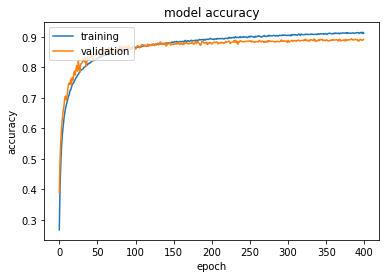

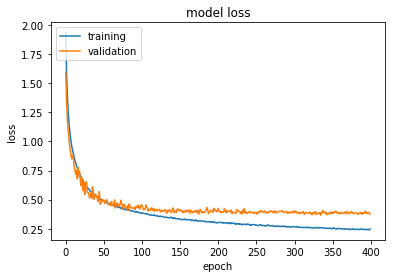


Computing EOT Score...
10000/10000 [==============================] - 66s 7ms/step
Test Accuracy with EOT Weights: 0.8916

Computing Best Weights Score...
10000/10000 [==============================] - 65s 6ms/step
Test Accuracy with Best Weights: 0.8936


In [14]:
# function for evaluating performance
this_score = evaluate_performance(
    model_obj=model_WRN,   
    model_dir=this_dir,       
    X_test_data=X_test,     
    y_test_data=y_test,
    test_generator=test_datagen,
    model_hist=this_history,               
    model_lr_hist=None)


This WRN model achieved a test accuracy of **89.3%**, roughly 3% better than the VGG model we trained earlier, while using only half of the model parameters. Note that state-of-the-art performance for WRNs on CIFAR-10 is closer to 95% accuracy. Hence, with further parameter tuning, our model certainly has room for improvement. From the plots of accuracy and loss versus epoch, our metrics haven't quite plateaued yet, so we might also consider training our model for additonal epochs.

### View Sample Predictions

As before, let's view some sample predictions, just for fun!


**Displaying Correct Predictions**


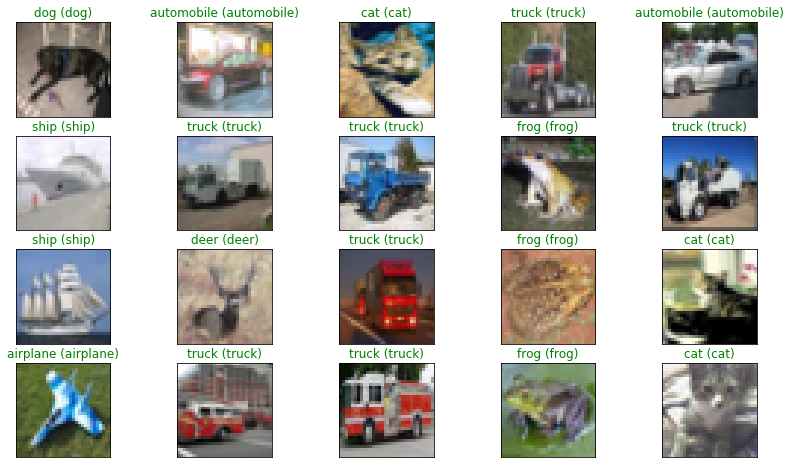

In [16]:
# generate the predictions
test_generator = test_datagen.flow(X_test, 
                                   get_onehot(y_test), 
                                   batch_size=1)

probas = model_WRN.predict_generator(test_generator,
                                      steps=len(y_test))
preds_WRN = np.argmax(probas, axis=1)

# view correct predictions
view_predictions(model_WRN, preds_WRN, condition='Correct')


**Displaying Incorrect Predictions**


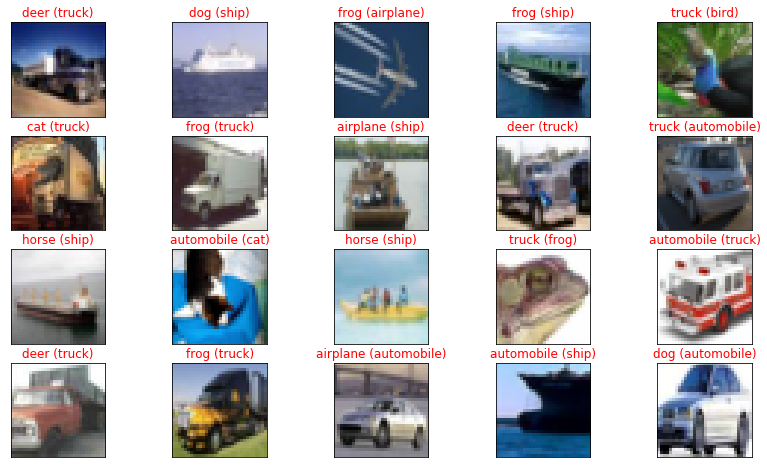

In [17]:
# view incorrect predictions
view_predictions(model_WRN, preds_WRN, condition='Incorrect')

### Using Image Augmentation Scheme 2:

Finally, to wrap things up, let's see how our model performs with a different image augmentation scheme. First we'll add some flips and rotations to the mix:

In [11]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_WRN = build_WRN(40, 2, drop_rate=0.3)

# define the optimizer initial settings
sgd = K.optimizers.SGD(
    lr=0.1, 
    decay=0.0005,
    momentum=0.9, 
    nesterov=True)

# initiate training
this_name = 'WRN_AugScheme2_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_WRN,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_2,
    test_generator=test_datagen,
    BATCH_SIZE=128,                 
    EPOCHS=400,                
    optimizer=sgd,                
    lr_schedule_fn=None)

To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=/home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme2_FullTrainSet/20180916-224335/logs


Epoch 1/400
391/390 [==============================] - 107s 273ms/step - loss: 1.8240 - acc: 0.3137 - val_loss: 1.7855 - val_acc: 0.3664

Epoch 00001: val_loss improved from inf to 1.78550, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme2_FullTrainSet/20180916-224335/best_weights.hdf5
Epoch 2/400
391/390 [==============================] - 109s 280ms/step - loss: 1.4506 - acc: 0.4656 - val_loss: 1.5409 - val_acc: 0.4360

Epoch 00002: val_loss improved from 1.78550 to 1.54093, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme2_FullTrainSet/20180916-224335/best_weights.hdf5
Epoch 3/400
391/390 [==============================] - 110s 280ms/step - loss: 1.2650 - acc: 0.5438 - val_loss: 1.1097 - val_acc: 0.5983

Epoch 00003: val_loss improved fro

Epoch 32/400
391/390 [==============================] - 97s 249ms/step - loss: 0.5330 - acc: 0.8126 - val_loss: 0.6729 - val_acc: 0.7917

Epoch 00032: val_loss did not improve from 0.58298
Epoch 33/400
391/390 [==============================] - 98s 251ms/step - loss: 0.5273 - acc: 0.8158 - val_loss: 0.5813 - val_acc: 0.8115

Epoch 00033: val_loss improved from 0.58298 to 0.58127, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme2_FullTrainSet/20180916-224335/best_weights.hdf5
Epoch 34/400
391/390 [==============================] - 98s 250ms/step - loss: 0.5200 - acc: 0.8195 - val_loss: 0.6392 - val_acc: 0.7986

Epoch 00034: val_loss did not improve from 0.58127
Epoch 35/400
391/390 [==============================] - 98s 251ms/step - loss: 0.5145 - acc: 0.8209 - val_loss: 0.5233 - val_acc: 0.8325

Epoch 00035: val_loss improved from 0.58127 to 0.52335, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme2_FullTrainSet/20180916-224335/best_w

391/390 [==============================] - 95s 243ms/step - loss: 0.3371 - acc: 0.8805 - val_loss: 0.4936 - val_acc: 0.8542

Epoch 00112: val_loss did not improve from 0.44989
Epoch 113/400
391/390 [==============================] - 95s 244ms/step - loss: 0.3343 - acc: 0.8821 - val_loss: 0.5082 - val_acc: 0.8521

Epoch 00113: val_loss did not improve from 0.44989
Epoch 114/400
391/390 [==============================] - 95s 243ms/step - loss: 0.3334 - acc: 0.8827 - val_loss: 0.4969 - val_acc: 0.8546

Epoch 00114: val_loss did not improve from 0.44989
Epoch 115/400
391/390 [==============================] - 95s 244ms/step - loss: 0.3299 - acc: 0.8847 - val_loss: 0.5383 - val_acc: 0.8451

Epoch 00115: val_loss did not improve from 0.44989
Epoch 116/400
391/390 [==============================] - 96s 245ms/step - loss: 0.3270 - acc: 0.8838 - val_loss: 0.5008 - val_acc: 0.8539

Epoch 00116: val_loss did not improve from 0.44989
Epoch 117/400
391/390 [==============================] - 106s 27

391/390 [==============================] - 117s 300ms/step - loss: 0.2731 - acc: 0.9037 - val_loss: 0.4587 - val_acc: 0.8700

Epoch 00196: val_loss did not improve from 0.41605
Epoch 197/400
391/390 [==============================] - 118s 302ms/step - loss: 0.2727 - acc: 0.9048 - val_loss: 0.4658 - val_acc: 0.8665

Epoch 00197: val_loss did not improve from 0.41605
Epoch 198/400
391/390 [==============================] - 107s 274ms/step - loss: 0.2654 - acc: 0.9053 - val_loss: 0.5258 - val_acc: 0.8577

Epoch 00198: val_loss did not improve from 0.41605
Epoch 199/400
391/390 [==============================] - 104s 266ms/step - loss: 0.2689 - acc: 0.9039 - val_loss: 0.4917 - val_acc: 0.8634

Epoch 00199: val_loss did not improve from 0.41605
Epoch 200/400
391/390 [==============================] - 99s 254ms/step - loss: 0.2671 - acc: 0.9035 - val_loss: 0.5078 - val_acc: 0.8605

Epoch 00200: val_loss did not improve from 0.41605
Epoch 201/400
391/390 [==============================] - 106

391/390 [==============================] - 98s 251ms/step - loss: 0.2392 - acc: 0.9132 - val_loss: 0.4564 - val_acc: 0.8758

Epoch 00282: val_loss did not improve from 0.41605
Epoch 283/400
391/390 [==============================] - 98s 250ms/step - loss: 0.2353 - acc: 0.9170 - val_loss: 0.5001 - val_acc: 0.8658

Epoch 00283: val_loss did not improve from 0.41605
Epoch 284/400
391/390 [==============================] - 98s 250ms/step - loss: 0.2380 - acc: 0.9150 - val_loss: 0.4533 - val_acc: 0.8762

Epoch 00284: val_loss did not improve from 0.41605
Epoch 285/400
391/390 [==============================] - 95s 243ms/step - loss: 0.2335 - acc: 0.9165 - val_loss: 0.4525 - val_acc: 0.8753

Epoch 00285: val_loss did not improve from 0.41605
Epoch 286/400
391/390 [==============================] - 96s 245ms/step - loss: 0.2374 - acc: 0.9145 - val_loss: 0.4599 - val_acc: 0.8739

Epoch 00286: val_loss did not improve from 0.41605
Epoch 287/400
391/390 [==============================] - 96s 246

391/390 [==============================] - 107s 275ms/step - loss: 0.2098 - acc: 0.9259 - val_loss: 0.4836 - val_acc: 0.8753

Epoch 00368: val_loss did not improve from 0.41605
Epoch 369/400
391/390 [==============================] - 123s 314ms/step - loss: 0.2113 - acc: 0.9246 - val_loss: 0.4533 - val_acc: 0.8800

Epoch 00369: val_loss did not improve from 0.41605
Epoch 370/400
391/390 [==============================] - 122s 313ms/step - loss: 0.2107 - acc: 0.9248 - val_loss: 0.4860 - val_acc: 0.8742

Epoch 00370: val_loss did not improve from 0.41605
Epoch 371/400
391/390 [==============================] - 123s 315ms/step - loss: 0.2110 - acc: 0.9245 - val_loss: 0.4403 - val_acc: 0.8809

Epoch 00371: val_loss did not improve from 0.41605
Epoch 372/400
391/390 [==============================] - 123s 315ms/step - loss: 0.2100 - acc: 0.9242 - val_loss: 0.4667 - val_acc: 0.8782

Epoch 00372: val_loss did not improve from 0.41605
Epoch 373/400
391/390 [==============================] - 11


Plotting Training History:


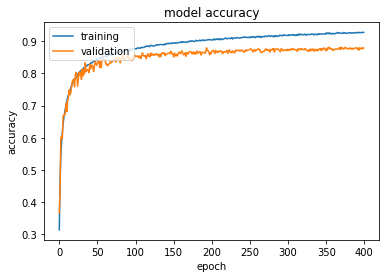

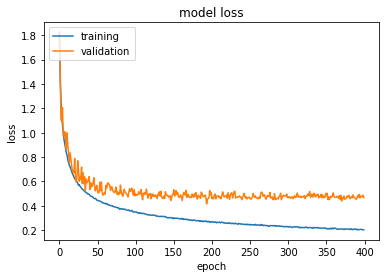


Computing EOT Score...
10000/10000 [==============================] - 64s 6ms/step
Test Accuracy with EOT Weights: 0.8791

Computing Best Weights Score...
10000/10000 [==============================] - 65s 7ms/step
Test Accuracy with Best Weights: 0.8791


In [14]:
# function for evaluating performance
this_score = evaluate_performance(
    model_obj=model_WRN,   
    model_dir=this_dir,       
    X_test_data=X_test,     
    y_test_data=y_test,
    test_generator=test_datagen,
    model_hist=this_history,               
    model_lr_hist=None)


We see that the original image augmentation scheme was better - in this case we clearly have poorer model generalization as indicated by the significantly wider gap between the training and validation curves. 

### Using Std/Mean Normalization:

Let's also examine what happens if we normalize our data based on mean and standard deviation, rather than via ZCA whitening:

In [20]:
# define a new image data generator
train_datagen_3 = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False, 
    featurewise_std_normalization=True,  # ADDED 
    samplewise_std_normalization=False, 
    zca_whitening=False,  # MODIFIED 
    zca_epsilon=1e-06, 
    rotation_range=0.0, 
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='reflect', 
    cval=0.0, 
    horizontal_flip=True, 
    vertical_flip=False, 
    rescale=None, # REVERTED
    preprocessing_function=None, 
    data_format='channels_last', 
    validation_split=0.0)

# modify the test set generator to use std/mean
# standardization
test_datagen_2 = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, # ADDED
    zca_whitening=False, # MODIFIED
    rescale=None,   # REVERTED
    data_format='channels_last')

train_datagen_3.fit(np.vstack((X_train, X_val)))
test_datagen_2.fit(np.vstack((X_train, X_val)))

In [22]:
# reset the tensorflow graph
K.backend.clear_session()

# construct model
model_WRN = build_WRN(40, 2, drop_rate=0.3)

# define the optimizer initial settings
sgd = K.optimizers.SGD(
    lr=0.1, 
    decay=0.0005,
    momentum=0.9, 
    nesterov=True)

# initiate training
this_name = 'WRN_AugScheme4(StdNorm)_FullTrainSet'

(this_history, this_dir) = compile_and_train(
    model=model_WRN,              
    MODEL_NAME=this_name,              
    X_train_data=np.vstack((X_train, X_val)),                
    y_train_data=np.hstack((y_train, y_val)),           
    X_val_data=X_test,                
    y_val_data=y_test, 
    train_generator=train_datagen_3,
    test_generator=test_datagen_2,
    BATCH_SIZE=128,                 
    EPOCHS=400,                
    optimizer=sgd,                
    lr_schedule_fn=None)

To view graph generated by TensorBoard,
copy+paste the following into terminal:

tensorboard --logdir=/home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme4(StdNorm)_FullTrainSet/20180917-123802/logs


Epoch 1/400
391/390 [==============================] - 34s 86ms/step - loss: 1.8963 - acc: 0.2920 - val_loss: 1.7754 - val_acc: 0.3590

Epoch 00001: val_loss improved from inf to 1.77542, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme4(StdNorm)_FullTrainSet/20180917-123802/best_weights.hdf5
Epoch 2/400
391/390 [==============================] - 32s 81ms/step - loss: 1.6243 - acc: 0.3996 - val_loss: 1.4529 - val_acc: 0.4749

Epoch 00002: val_loss improved from 1.77542 to 1.45293, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme4(StdNorm)_FullTrainSet/20180917-123802/best_weights.hdf5
Epoch 3/400
391/390 [==============================] - 32s 81ms/step - loss: 1.4859 - acc: 0.4578 - val_loss: 1.3562 - val_acc: 0.5061

Epoch 00003: 


Epoch 00065: val_loss did not improve from 0.44334
Epoch 66/400
391/390 [==============================] - 31s 78ms/step - loss: 0.4566 - acc: 0.8410 - val_loss: 0.4581 - val_acc: 0.8544

Epoch 00066: val_loss did not improve from 0.44334
Epoch 67/400
391/390 [==============================] - 31s 78ms/step - loss: 0.4572 - acc: 0.8391 - val_loss: 0.4566 - val_acc: 0.8546

Epoch 00067: val_loss did not improve from 0.44334
Epoch 68/400
391/390 [==============================] - 31s 78ms/step - loss: 0.4510 - acc: 0.8419 - val_loss: 0.4292 - val_acc: 0.8621

Epoch 00068: val_loss improved from 0.44334 to 0.42921, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme4(StdNorm)_FullTrainSet/20180917-123802/best_weights.hdf5
Epoch 69/400
391/390 [==============================] - 31s 78ms/step - loss: 0.4503 - acc: 0.8418 - val_loss: 0.4376 - val_acc: 0.8580

Epoch 00069: val_loss did not improve from 0.42921
Epoch 70/400
391/390 [==============================] - 30s

391/390 [==============================] - 31s 79ms/step - loss: 0.3406 - acc: 0.8793 - val_loss: 0.3966 - val_acc: 0.8758

Epoch 00145: val_loss did not improve from 0.38940
Epoch 146/400
391/390 [==============================] - 31s 78ms/step - loss: 0.3436 - acc: 0.8789 - val_loss: 0.3873 - val_acc: 0.8776

Epoch 00146: val_loss improved from 0.38940 to 0.38730, saving model to /home/rpm/Dropbox/Keras-Devs/models/CIFAR-10/WRN_AugScheme4(StdNorm)_FullTrainSet/20180917-123802/best_weights.hdf5
Epoch 147/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3343 - acc: 0.8814 - val_loss: 0.3907 - val_acc: 0.8809

Epoch 00147: val_loss did not improve from 0.38730
Epoch 148/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3403 - acc: 0.8791 - val_loss: 0.3879 - val_acc: 0.8789

Epoch 00148: val_loss did not improve from 0.38730
Epoch 149/400
391/390 [==============================] - 31s 78ms/step - loss: 0.3369 - acc: 0.8807 - val_loss: 0.4022 - 

391/390 [==============================] - 31s 78ms/step - loss: 0.3157 - acc: 0.8878 - val_loss: 0.3868 - val_acc: 0.8829

Epoch 00185: val_loss did not improve from 0.37523
Epoch 186/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3135 - acc: 0.8904 - val_loss: 0.3965 - val_acc: 0.8811

Epoch 00186: val_loss did not improve from 0.37523
Epoch 187/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3101 - acc: 0.8902 - val_loss: 0.3863 - val_acc: 0.8839

Epoch 00187: val_loss did not improve from 0.37523
Epoch 188/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3088 - acc: 0.8917 - val_loss: 0.3929 - val_acc: 0.8824

Epoch 00188: val_loss did not improve from 0.37523
Epoch 189/400
391/390 [==============================] - 31s 79ms/step - loss: 0.3099 - acc: 0.8907 - val_loss: 0.3873 - val_acc: 0.8847

Epoch 00189: val_loss did not improve from 0.37523
Epoch 190/400
391/390 [==============================] - 31s 78ms/ste


Epoch 00227: val_loss did not improve from 0.37308
Epoch 228/400
391/390 [==============================] - 32s 81ms/step - loss: 0.2861 - acc: 0.8994 - val_loss: 0.3834 - val_acc: 0.8868

Epoch 00228: val_loss did not improve from 0.37308
Epoch 229/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2903 - acc: 0.8972 - val_loss: 0.3862 - val_acc: 0.8861

Epoch 00229: val_loss did not improve from 0.37308
Epoch 230/400
391/390 [==============================] - 31s 80ms/step - loss: 0.2870 - acc: 0.8985 - val_loss: 0.3868 - val_acc: 0.8870

Epoch 00230: val_loss did not improve from 0.37308
Epoch 231/400
391/390 [==============================] - 32s 81ms/step - loss: 0.2885 - acc: 0.8974 - val_loss: 0.3897 - val_acc: 0.8866

Epoch 00231: val_loss did not improve from 0.37308
Epoch 232/400
391/390 [==============================] - 31s 80ms/step - loss: 0.2875 - acc: 0.8969 - val_loss: 0.3945 - val_acc: 0.8864

Epoch 00232: val_loss did not improve from 0.37308
Epo


Epoch 00312: val_loss did not improve from 0.37147
Epoch 313/400
391/390 [==============================] - 30s 78ms/step - loss: 0.2550 - acc: 0.9093 - val_loss: 0.3802 - val_acc: 0.8922

Epoch 00313: val_loss did not improve from 0.37147
Epoch 314/400
391/390 [==============================] - 30s 78ms/step - loss: 0.2589 - acc: 0.9077 - val_loss: 0.3936 - val_acc: 0.8885

Epoch 00314: val_loss did not improve from 0.37147
Epoch 315/400
391/390 [==============================] - 30s 78ms/step - loss: 0.2527 - acc: 0.9104 - val_loss: 0.3840 - val_acc: 0.8916

Epoch 00315: val_loss did not improve from 0.37147
Epoch 316/400
391/390 [==============================] - 30s 78ms/step - loss: 0.2541 - acc: 0.9089 - val_loss: 0.3817 - val_acc: 0.8914

Epoch 00316: val_loss did not improve from 0.37147
Epoch 317/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2562 - acc: 0.9084 - val_loss: 0.3835 - val_acc: 0.8909

Epoch 00317: val_loss did not improve from 0.37147
Epo

391/390 [==============================] - 31s 79ms/step - loss: 0.2397 - acc: 0.9141 - val_loss: 0.3877 - val_acc: 0.8930

Epoch 00356: val_loss did not improve from 0.37147
Epoch 357/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2438 - acc: 0.9123 - val_loss: 0.3883 - val_acc: 0.8925

Epoch 00357: val_loss did not improve from 0.37147
Epoch 358/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2398 - acc: 0.9148 - val_loss: 0.3899 - val_acc: 0.8930

Epoch 00358: val_loss did not improve from 0.37147
Epoch 359/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2443 - acc: 0.9116 - val_loss: 0.3820 - val_acc: 0.8940

Epoch 00359: val_loss did not improve from 0.37147
Epoch 360/400
391/390 [==============================] - 31s 79ms/step - loss: 0.2410 - acc: 0.9137 - val_loss: 0.3995 - val_acc: 0.8902

Epoch 00360: val_loss did not improve from 0.37147
Epoch 361/400
391/390 [==============================] - 31s 79ms/ste


Plotting Training History:


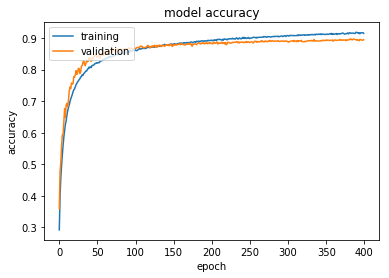

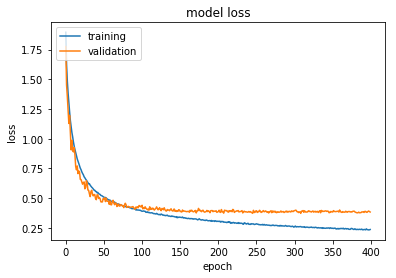


Computing EOT Score...
10000/10000 [==============================] - 53s 5ms/step
Test Accuracy with EOT Weights: 0.8948

Computing Best Weights Score...
10000/10000 [==============================] - 59s 6ms/step
Test Accuracy with Best Weights: 0.8926


In [23]:
# function for evaluating performance
this_score = evaluate_performance(
    model_obj=model_WRN,   
    model_dir=this_dir,       
    X_test_data=X_test,     
    y_test_data=y_test,
    test_generator=test_datagen_3,
    model_hist=this_history,               
    model_lr_hist=None)


In this case, the performance difference between ZCA and std/mean normalization was negligible. 

<a id='section_4'></a>
***
## 4) Final Remarks

In this tutorial we saw how Keras could be used to rapidly build complex machine learning models from the ground up. We first trained a VGG model using the `Sequential()` model API, and then implemented a more sophisticated Wide Residual Network using the Functional API. 

As well-put by Keras creator Francois Chollet, *"your final models will typically share little in common with the solutions you envisioned when first approaching the problem ...a-priori plans basically never survive confrontation with experimental reality."* So get out there, build 'em, and iterate!